In [127]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import os
from sys import platform
import f90nml
from importlib import reload
import sys
sys.path.append('../ice2019')
import retrievestuff as rs
import weibull

In [128]:
%matplotlib notebook

In [129]:
def Weibull(Z2,sigma2W,etaW):
    # Getting the Weibull distribution
    rhoW = etaW/(sigma2W)*(Z2/sigma2W)**(etaW-1)*np.exp(-(Z2/sigma2W)**etaW)
    return rhoW

In [130]:
# Have to do this in case of different operating systems
if platform == "linux" or platform == "darwin":
    slash = '/'
else: # This is assumed to be Windows
    slash = '\\'
#print(slash)

In [131]:
# This is the folder name
#foldername = "Fri Mar 29 13_43_02 2019"; filename = "surface.txt"
#foldername = "Case2.0 (calibration)"; filename = "surface_filtered.txt"

isegment = 1
Z2max = 0.1
scale = 1
foldername = "Thu May 23 14_59_14 2019";  Z2max = 0.004; filename = "surface"+str(isegment)+".txt"; scale = 0.25
#foldername = "2018-07-05"+slash+"Case2.0 (calibration)"; Z2max = .005; filename = "surface_filtered"+str(isegment)+".txt"
#foldername = "2018-07-05"+slash+"Case2.2"; Z2max = .1;
print(foldername)
print(filename)

#Load a height file (for synthetic data)
#filename = "surface.txt"

sollast = np.loadtxt(foldername+slash+filename)*scale
Ny, Nx = np.shape(sollast); #print(sollast.shape)
Ntot = np.size(sollast)
print("Nx =", Nx)
print("Ny =", Ny)
print('Npts = ', Ntot)

# Get other parameters
params = f90nml.read(foldername+slash+'parameters'+str(isegment)+'.nml')
Lx = params['parameters']['Lx']; print("Lx =", Lx)
Ly = params['parameters']['Ly']; print("Ly =", Ly)

Thu May 23 14_59_14 2019
surface1.txt
Nx = 151
Ny = 150
Npts =  22650
Lx = 20
Ly = 20


In [132]:
# Get the x and y axes as arrays and grids
x = np.linspace(0,Lx,Nx); #print(x[1]-x[0])
y = np.linspace(0,Ly,Ny); 
xgrid,ygrid = np.meshgrid(x,y); #print(xgrid.shape)
dx = x[1]-x[0]
dy = y[1]-y[0]

<IPython.core.display.Javascript object>


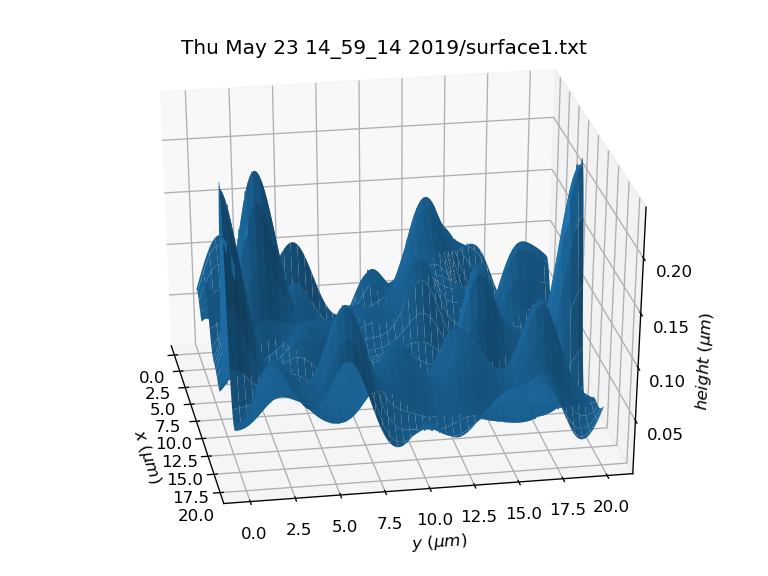

Text(0.5,0,'$height \\ (\\mu m)$')

In [133]:
# Plot the surface as a mesh
fig1 = plt.figure()
ax = fig1.add_subplot(111, projection='3d')
ax.plot_surface(xgrid, ygrid, sollast)
ax.set_title(foldername+slash+filename)
ax.view_init(30, -10)
ax.set_xlabel('$x \ (\mu m)$')
ax.set_ylabel('$y \ (\mu m)$')
ax.set_zlabel('$height \ (\mu m)$')

In [134]:
# Get the probability distribution in Z2
nbins_max = 10
nbins_sturges = int(1+3.3*np.log10(Ntot)); print('Sturges rule says nbins = ', nbins_sturges)
nbins = np.min([nbins_max,nbins_sturges]); print('Using nbins = ', nbins)
Z2bins = np.linspace(0,Z2max,nbins-1)
counts, bins, meanZ2, error = rs.getrhoofz2(sollast,dx,dy,Z2bins=Z2bins,levels=3)
# print(counts)
# print(error)
print('meanZ2 = ', meanZ2)
print('statsigma = ', np.sqrt(meanZ2))

Sturges rule says nbins =  15
Using nbins =  10
Original =  22350
4 0 5588 [2276 1068  704  379  243  229  105   99]
4 1 5588 [2286 1063  703  375  277  180  120   97]
4 2 5587 [2290 1053  692  385  282  178  128   96]
4 3 5587 [2294 1051  684  406  261  176  137   92]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
meanZ2 =  0.0014884231372829316
statsigma =  0.038580087315646806


(22350,)
mean Z2 =  0.0014884231372829316
integral =  0.0003832622862462639


<IPython.core.display.Javascript object>


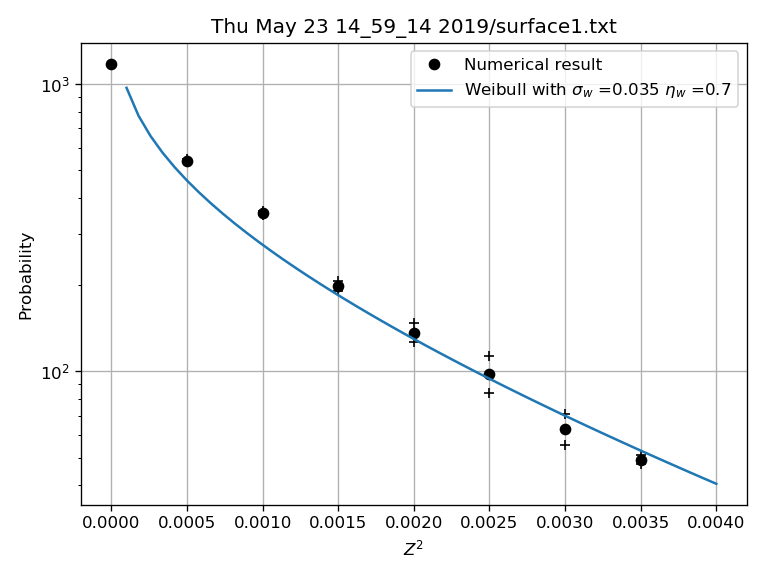

[1169.26617233  541.4216313   355.79135771  197.5198159   135.89874712
   97.54538481   62.64382511   49.09230376]
[1174.0151245   546.4004768   361.6534636   205.99978442  146.72773337
  113.25482772   70.99089107   50.90221782]
[1164.53642993  536.48815344  350.02427174  189.38892478  125.86897545
   84.01498011   55.27820211   47.34674424]


<IPython.core.display.Javascript object>


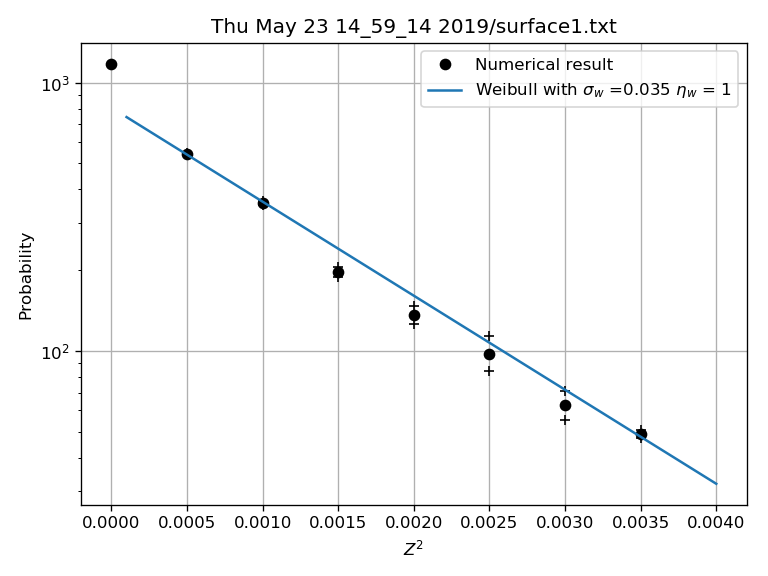

[1169.26617233  541.4216313   355.79135771  197.5198159   135.89874712
   97.54538481   62.64382511   49.09230376]
[1174.0151245   546.4004768   361.6534636   205.99978442  146.72773337
  113.25482772   70.99089107   50.90221782]
[1164.53642993  536.48815344  350.02427174  189.38892478  125.86897545
   84.01498011   55.27820211   47.34674424]


Text(0,0.5,'Probability')

In [135]:
x = np.linspace(0,Lx,Nx)
y = np.linspace(0,Ly,Ny) 
xgrid,ygrid = np.meshgrid(x,y)
dx = x[1]-x[0]
dy = y[1]-y[0]
dzdx = np.diff(sollast, axis=0)/dx
dzdy = np.diff(sollast, axis = 1)/dy #we are not sure which axis is which
Z2 = dzdx[:, 1:]**2+dzdy[1:, :]**2
Z2flat = np.reshape(Z2, (Nx-1)*(Ny-1))
print(np.shape(Z2flat))

# Normalizes the experimental distribution function
print('mean Z2 = ', np.mean(Z2))
integral_rho = np.trapz(counts, bins)
print('integral = ', integral_rho)
counts = counts/integral_rho
error = error/integral_rho

analysis = weibull.Analysis(Z2flat)
analysis.fit(method='mle')
etaW = analysis.beta
sigma2W = analysis.eta
sigmaW = np.sqrt(sigma2W)

fig = plt.figure()
plt.semilogy(bins, counts, 'ok', label='Numerical result')


# Graphing the error bars (sloppily)
print(counts)
countsplus = counts+error; print(countsplus)
countsminus = counts**2/countsplus; print(countsminus)
plt.semilogy(bins, countsplus, '+k')
plt.semilogy(bins, countsminus,'+k')

# Graph the best-fit distribution function
Z2 = np.linspace(0.0001,Z2max,50)
myWeibull = Weibull(Z2,sigma2W,etaW)
plt.semilogy(Z2, myWeibull, label = 'Weibull with $\sigma_w$ =' + str(sigmaW)[0:5] + ' $\eta_w$ =' + str(etaW)[0:3])
plt.grid(True)
plt.legend()
plt.title(foldername+slash+filename)
plt.xlabel('$Z^2$')
plt.ylabel('Probability')

fig = plt.figure()
plt.semilogy(bins, counts, 'ok', label='Numerical result')

# Graphing the error bars (sloppily)
print(counts)
countsplus = counts+error; print(countsplus)
countsminus = counts**2/countsplus; print(countsminus)
plt.semilogy(bins, countsplus, '+k')
plt.semilogy(bins, countsminus,'+k')

# Graph the best-fit distribution function
Z2 = np.linspace(0.0001,Z2max,50)
myWeibull = Weibull(Z2,sigma2W,1)
plt.semilogy(Z2, myWeibull, label = 'Weibull with $\sigma_w$ =' + str(sigmaW)[0:5] + ' $\eta_w$ = 1')
plt.grid(True)
plt.legend()
plt.title(foldername+slash+filename)
plt.xlabel('$Z^2$')
plt.ylabel('Probability')


In [136]:
# cfile = open(foldername+"/roughness_parameters"+str(isegment)+".nml", "w")
# cfile.write('&roughness_parameters\n')
# cfile.write('   '+"sigma_W = "+str(sigmaW)+"\n")
# cfile.write('   '+"eta_W = "+str(etaW)+"\n")
# cfile.write('/ \n')
# cfile.close()